In [95]:
from neo4j import __version__ as neo4j_version
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
import import_ipynb
from louvain_ascendency import*
from mixer_ascendency import*
from Neo4j import *
import matplotlib.pyplot as plt

In [134]:
conn = Neo4jConnection(uri="bolt://localhost:7687", 
                       user="neo4j",              
                       pwd="uniswap")

In [139]:
class graph_analyser():
    
    def __init__(self, conn, graph_name):
        self.conn = conn
        self.addresses_in_large_communities = {} # communitity id => addresses in community
        self.large_communities = [] # stores ids of large communities
        self.subgraphs = {} # adjacency matrices of subgraphs of all communities 
        self.metrics_by_community = {} # dict of dicts of graph state metrics by community
        self.metric_names = ["Average Mutual Information", "Development capacity", "Ascendency", "Redundancy"]
        self.address_to_node_by_subgraph = {} # dicts of address to node in each subgraph
        self.graph_name = graph_name 
        self.remove_full_graph_from_neo4j()
        self.create_token_graph_neo4j()
        self.centrality_scores_by_community = {}
        

        
    def create_token_graph_neo4j(self):
        name = self.graph_name 
        print(name)
        
        query_string = '''CALL gds.graph.create(
                            '%s',
                            'Address',
                            {
                                TRANSFER_%s: {
                                    type: 'TRANSFERED_%s',
                                    orientation: 'NATURAL',
                                    properties: 'value'

                                }
                            }
                        )''' %(name, name, name)
        self.conn.query(query_string)
    
    def check_if_graph_exists_neo4j(self):
        query_string = "CALL gds.graph.exists('%s')"%(self.graph_name)
        exists = self.conn.query(query_string)
        response_df = pd.DataFrame([dict(_) for _ in exists])
        
        return response_df['exists'][0]
    
    def run_louvain(self, threshold):
        
        query_string = '''CALL gds.louvain.write(
                        '%s',
                        {
                            tolerance: %d,
                            writeProperty: 'communityId',
                            relationshipWeightProperty: 'value'
                        }
                    )'''%(self.graph_name, threshold)
        self.conn.query(query_string)
        
    def create_subgraph_from_community_id(self, community_id):
        query_string = '''CALL gds.graph.create.cypher(
                        'community-%d',
                        'MATCH (n) WHERE n.communityId = %d RETURN id(n) AS id',
                        'MATCH (n)-[r:TRANSFERED_UNI]->(m) WHERE n.communityId = %d AND m.communityId = %d RETURN id(n) AS source, id(m) AS target, r.value AS value'
                    ) ''' %(community_id, community_id, community_id, community_id)
        self.conn.query(query_string)
        
    def calculate_subgraph_centrality(self, community_id):
        query_string = '''CALL gds.degree.stream('community-%d')
                            YIELD nodeId, score
                            RETURN gds.util.asNode(nodeId).id AS address, score AS degreeCentrality
                            ORDER BY degreeCentrality DESC''' %(community_id)
        centrality_scores = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        
        return centrality_scores
    
    def remove_all_community_ids(self):
        
        query_string = '''MATCH (n:Address)
                            REMOVE n.communityId
                            RETURN n '''
        self.conn.query(query_string)
    
    def calculate_centrality_score_for_every_community(self):
        
        for community_id in self.large_communities:
            self.create_subgraph_from_community_id(community_id)
            self.centrality_scores_by_community[community_id] = self.calculate_subgraph_centrality(community_id)
            self.remove_graph_from_neo4j(community_id)
            
    def remove_graph_from_neo4j(self, community_id):
        
        query_string = '''CALL gds.graph.drop('community-%d')''' %(community_id)
        self.conn.query(query_string)
        
    def remove_full_graph_from_neo4j(self):
        query_string = '''CALL gds.graph.drop('%s')''' %(self.graph_name)
        self.conn.query(query_string)
        
    def find_large_communities(self, threshold):
        query_string = '''MATCH (n:Address)
                        WHERE EXISTS(n.communityId)
                        RETURN n.communityId AS communityId, COUNT(*) AS size
                        ORDER BY size DESC'''

        size_of_communities = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        
        for index, row in size_of_communities.iterrows():
            if(row['size'] > threshold):
                self.large_communities.append(row['communityId'])
        return self.large_communities
    
    def get_all_community_addresses(self, community_id):
        query_string = '''MATCH (n)
                          WHERE n.communityId = ''' 
        query_string = query_string + str(community_id) 
        query_string += '''RETURN n.id as id'''

        addresses_in_community = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        return addresses_in_community['id'].tolist()
    
    def get_all_addresses_from_large_communities(self):
        
        for community in self.large_communities:
            self.addresses_in_large_communities[community] = self.get_all_community_addresses(community)
        
    def get_node_degree(self, node_address):
    
        query_string = '''MATCH (n:Address {id: \"'''
        query_string += str(node_address)
        query_string +=  '"})'
        query_string += '''RETURN apoc.node.degree(n) AS degree '''

        degree = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])

        return degree['degree'][0]
    
    def get_address_with_highest_degree(self, community_id):
        a = "0x"
        highest_degree = 0
        for address in self.large_communities[community_id]:
            node_degree = self.get_node_degree(address, self.conn)
            if node_degree > highest_degree:
                highest_degree = node_degree
                a = address

        return a, highest_degree
    
    def get_subgraph_by_community_id(self, community_id):
        
        query_string = '''MATCH (a1:Address)-[r:TRANSFERED_UNI]->(a2:Address)'''
        query_string += '''WHERE a1.communityId = ''' + str(community_id) 
        query_string +=  '''AND a2.communityId =''' + str(community_id)
        query_string += '''RETURN a1.id as From, a2.id as To, r.value as value'''

        subgraph = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        
        return subgraph
    
    def convert_subgraph_into_adj_matrix(self, subgraph):
        
        Graphtype = nx.DiGraph()
        G=nx.from_pandas_edgelist(subgraph, 'From', 'To', ['value'], create_using=Graphtype)
        g_numpy = nx.to_numpy_array(G)
        
        return g_numpy 
    
    def calculate_metrics(self, subgraph_adj_matrix):
       
        ami = measure_average_mutual_information(subgraph_adj_matrix)
        dc = measure_development_capacity(subgraph_adj_matrix)
        a = measure_ascendency(subgraph_adj_matrix)
        r = measure_redundancy(subgraph_adj_matrix)
        
        return ami, dc, a, r
    
    def find_all_subgraphs(self):
        
        for community_id in self.large_communities:
            graph_df = self.get_subgraph_by_community_id(community_id)
            self.subgraphs[community_id] = self.pandas_edge_list_to_adj_matrix(graph_df, community_id)
        
        
    def calculate_metrics_for_all_subgraphs(self):
        
        for community_id in self.subgraphs:
            self.metrics_by_community[community_id] ={}
            metrics = self.calculate_metrics(self.subgraphs[community_id])
            for count, metric in enumerate(metrics):
                self.metrics_by_community[community_id][self.metric_names[count]] = metric
    
    def pandas_edge_list_to_adj_matrix(self, graph_df, community_id):
        """
        From = graph_df['number_to']
        To = graph_df['number_from']
        all_addresses = From + To
        number_of_unique_addresses = np.unique(np.array(all_addresses))
        adj_matrix  = np.array((number_of_unique_addresses, number_of_unique_addresses))
        for index, row in graph_df.iterrows():
            adj_matrix[row[]]
        """
        
        #graph_df = pd.crosstab(graph_df.From, graph_df.To)
        
        address_to_node ={}
        count = 0
        for index, row in graph_df.iterrows():
            address = row["From"]
            if address not in address_to_node:
                address_to_node[address] = count 
                count += 1
            address = row["To"]
            if address not in address_to_node:
                address_to_node[address] = count 
                count += 1
        size = len(address_to_node.keys())
        
        adj_matrix = np.zeros((size, size))
        self.address_to_node_by_subgraph[community_id] = address_to_node
        
        for index, row in graph_df.iterrows():
            adj_matrix[address_to_node[row["From"]]][address_to_node[row["To"]]] = row["value"]
        
       
        return adj_matrix
    

    

In [140]:
analyser = graph_analyser(conn, 'UNI')

Query failed: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `UNI` does not exist on database `neo4j`.}
UNI


In [141]:
louvain_threshold = 0.0000001
min_community_size = 1
analyser.remove_all_community_ids()
analyser.run_louvain(louvain_threshold)
analyser.find_large_communities(min_community_size)
analyser.get_all_addresses_from_large_communities()
analyser.find_all_subgraphs()
analyser.calculate_centrality_score_for_every_community()
analyser.calculate_metrics_for_all_subgraphs()


louvain_ascendency.ipynb:104: RuntimeWarning: invalid value encountered in double_scalars
  "        \n",
mixer_ascendency.ipynb:44: RuntimeWarning: invalid value encountered in double_scalars
  "            \n",
mixer_ascendency.ipynb:59: RuntimeWarning: invalid value encountered in double_scalars
  "class blockchain:\n",


In [142]:
print(analyser.centrality_scores_by_community)

{7653:                                          address  degreeCentrality
0     0xb739d0895772dbb71a89a3754a160269068f0d45             526.0
1     0x21a31ee1afc51d94c2efccaa2092ad1028285549             131.0
2     0x28c6c06298d514db089934071355e5743bf21d60             116.0
3     0xdfd5293d8e347dfe59e90efd55b2956a1343963d             107.0
4     0xe93381fb4c4f14bda253907b18fad305d799241a              82.0
...                                          ...               ...
3891  0x3a9f9ea1ba87042161304270287cc76c974896e9               0.0
3892  0x15d9cddacc976fce114a6fc824a155c163c782d9               0.0
3893  0x6954a941b8c2e7bc5eb76f88744964fd1606fae5               0.0
3894  0x85993838941576174b2a201924acfdf9eaa80b37               0.0
3895  0x0b8ef8df27622878a0499e2b26c3db9cffa8c3d7               0.0

[3896 rows x 2 columns], 5205:                                         address  degreeCentrality
0    0x48c04ed5691981c42154c6167398f95e8f38a7ff              12.0
1    0xff26d7d5710b916b62

In [143]:
metrics_by_community = analyser.metrics_by_community
metric_names = analyser.metric_names

ami = np.array([])
dc = np.array([])
a = np.array([])
r = np.array([])
community_sizes = np.array([])
number_of_edges = np.array([])

for key in metrics_by_community:
    community_sizes = np.append(community_sizes, len(analyser.addresses_in_large_communities[key]))
    number_of_edges = np.append(number_of_edges, np.count_nonzero(analyser.subgraphs[key]))
    ami = np.append(ami, metrics_by_community[key][metric_names[0]])
    dc = np.append(dc, metrics_by_community[key][metric_names[1]])
    a = np.append(a, metrics_by_community[key][metric_names[2]])
    r = np.append(r, metrics_by_community[key][metric_names[3]])

all_metrics = [ami, dc, a, r]

for count, metric in enumerate(all_metrics):
    print("Mean of ", metric_names[count], " is ", np.average(metric))
    print("Standard Deviation of ", metric_names[count], " is ", np.std(metric))
    print("Max of ", metric_names[count], " is ", np.max(metric))
    print("Min of ", metric_names[count], " is ", np.min(metric))
    print(" ")
print(number_of_edges)

Mean of  Average Mutual Information  is  0.026482950884264094
Standard Deviation of  Average Mutual Information  is  0.09211251551767327
Max of  Average Mutual Information  is  0.6475222350454086
Min of  Average Mutual Information  is  -7.295016122338968e-17
 
Mean of  Development capacity  is  -5.235162722704403
Standard Deviation of  Development capacity  is  125.28075758269064
Max of  Development capacity  is  0.0
Min of  Development capacity  is  -3200.27171164559
 
Mean of  Ascendency  is  3.058220563427102
Standard Deviation of  Ascendency  is  77.53354089010021
Max of  Ascendency  is  1982.7843457173149
Min of  Ascendency  is  -1.599578185145265e-19
 
Mean of  Redundancy  is  -0.0425479901647036
Standard Deviation of  Redundancy  is  0.1297452547590346
Max of  Redundancy  is  0.0
Min of  Redundancy  is  -1.0355022132060479
 
[5.821e+03 2.010e+02 5.600e+01 4.700e+01 5.100e+01 4.300e+01 2.700e+01
 1.400e+01 1.200e+01 1.100e+01 1.100e+01 1.000e+01 1.000e+01 9.000e+00
 8.000e+00 8.0

Average Mutual Information


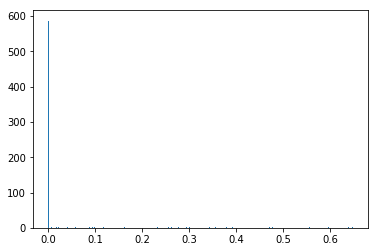

Development capacity


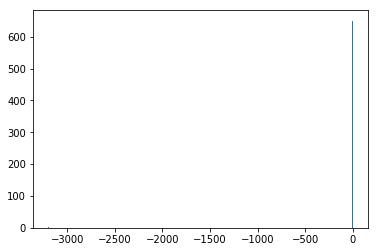

Ascendency


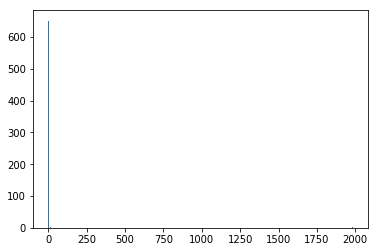

Redundancy


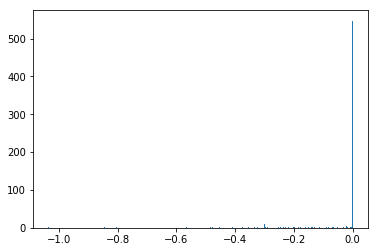

In [144]:
for count, metric in enumerate(all_metrics):
    print(metric_names[count])
    plt.hist(all_metrics[count], bins=len(all_metrics[count]))
    plt.show()

Average Mutual Information


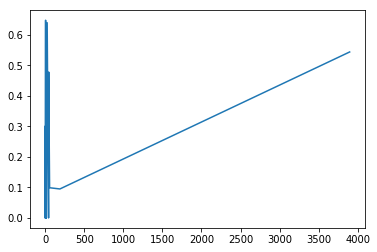

Development capacity


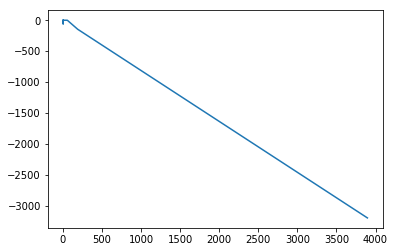

Ascendency


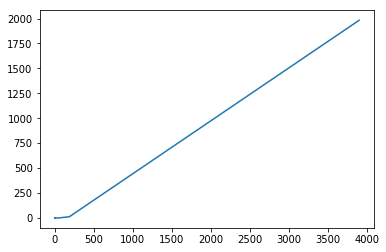

Redundancy


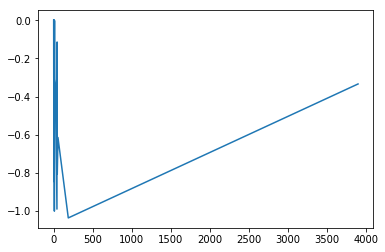

In [145]:

sorted_indicies = np.argsort(community_sizes)
community_sizes = community_sizes[sorted_indicies]

for count, metric in enumerate(all_metrics):
    print(metric_names[count])
    sorted_metric = all_metrics[count][sorted_indicies]
    plt.plot(community_sizes, sorted_metric)
    plt.show()

Average Mutual Information


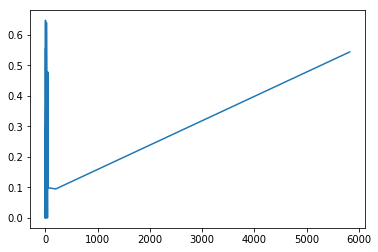

Development capacity


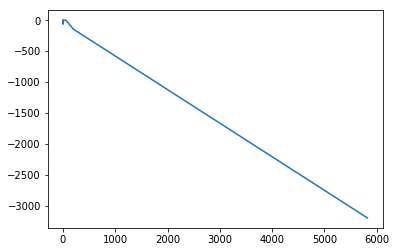

Ascendency


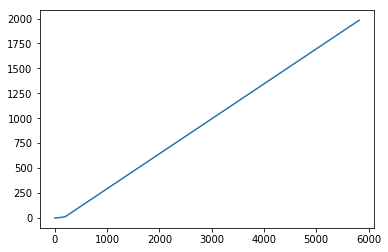

Redundancy


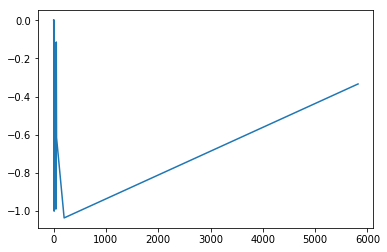

In [146]:
sorted_indicies = np.argsort(number_of_edges)
number_of_edges = number_of_edges[sorted_indicies]

for count, metric in enumerate(all_metrics):
    print(metric_names[count])
    sorted_metric = all_metrics[count][sorted_indicies]
    plt.plot(number_of_edges, sorted_metric)
    plt.show()